# ORCHARD BOUMAN CLUSTER

In [3]:
import numpy as np

class Node(object):

    def __init__(self, matrix, w):
        W = np.sum(w)
        self.w = w
        self.X = matrix
        self.left = None
        self.right = None
        self.mu = np.einsum('ij,i->j', self.X, w)/W
        diff = self.X - np.tile(self.mu, [(self.X.shape)[0], 1])
        t = np.einsum('ij,i->ij', diff, np.sqrt(w))
        self.cov = (t.T @ t)/W + 1e-5*np.eye(3)
        self.N = self.X.shape[0]
        V, D = np.linalg.eig(self.cov)
        self.lmbda = np.max(np.abs(V))
        self.e = D[np.argmax(np.abs(V))]


# S is measurements vector - dim nxd
# w is weights vector - dim n
def clustFunc(S, w, minVar=0.05):
    mu, sigma = [], []
    nodes = []
    nodes.append(Node(S, w))

    while max(nodes, key=lambda x: x.lmbda).lmbda > minVar:
        nodes = split(nodes)

    for i, node in enumerate(nodes):
        mu.append(node.mu)
        sigma.append(node.cov)

    return np.array(mu), np.array(sigma)


def split(nodes):
    idx_max = max(enumerate(nodes), key=lambda x: x[1].lmbda)[0]
    C_i = nodes[idx_max]
    idx = C_i.X @ C_i.e <= np.dot(C_i.mu, C_i.e)
    C_a = Node(C_i.X[idx], C_i.w[idx])
    C_b = Node(C_i.X[np.logical_not(idx)], C_i.w[np.logical_not(idx)])
    nodes.pop(idx_max)
    nodes.append(C_a)
    nodes.append(C_b)
    return nodes


# BAYESIAN MATTING 

C:\Users\Rakhil\AppData\Local\Temp\ipykernel_14564\389376039.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
C:\Users\Rakhil\AppData\Local\Temp\ipykernel_14564\389376039.py:166: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("gandalf.png")[:, :, :3]
C:\Users\Rakhil\AppData\Local\Temp\ipykernel_14564\389376039.py:167: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  trimap = imageio.imread("gandalfTrimap.png", mode='L')


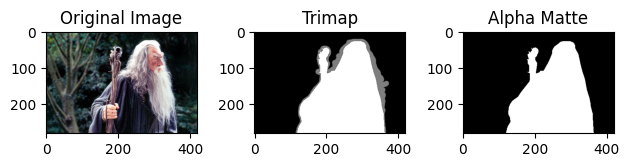

In [4]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import cv2
from numba import jit 


def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    2D Gaussian mask - similar to MATLAB's fspecial('gaussian', [shape], [sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


@jit(nopython=True, cache=True)
def get_window(m, x, y, N):
    h, w, c = m.shape
    halfN = N // 2
    r = np.zeros((N, N, c))
    xmin = max(0, x - halfN)
    xmax = min(w, x + (halfN+1))
    ymin = max(0, y - halfN)
    ymax = min(h, y + (halfN+1))
    pxmin = halfN - (x-xmin)
    pxmax = halfN + (xmax-x)
    pymin = halfN - (y-ymin)
    pymax = halfN + (ymax-y)

    r[pymin:pymax, pxmin:pxmax] = m[ymin:ymax, xmin:xmax]
    return r


@jit(nopython=True, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, sigma_C, alpha_init, max_iter, min_like):
    I = np.eye(3)
    F_max = np.zeros(3)
    B_max = np.zeros(3)
    alpha_max = 0
    max_like = -np.inf
    inv_sigma2 = 1 / sigma_C**2
    for i in range(mu_F.shape[0]):
        mu_Fi = mu_F[i]
        inv_sigma_Fi = np.linalg.inv(Sigma_F[i])
        for j in range(mu_B.shape[0]):
            mu_Bj = mu_B[j]
            inv_sigma_Bj = np.linalg.inv(Sigma_B[j])

            alpha = alpha_init
            my_iter = 1
            last_like = -1.7977e+308
            while True:
                # Solve for F, B
                A11 = inv_sigma_Fi + I * alpha**2 * inv_sigma2
                A12 = I * alpha * (1 - alpha) * inv_sigma2
                A22 = inv_sigma_Bj + I * (1 - alpha)**2 * inv_sigma2
                A = np.vstack((np.hstack((A11, A12)), np.hstack((A12, A22))))
                b1 = inv_sigma_Fi @ mu_Fi + C * (alpha) * inv_sigma2
                b2 = inv_sigma_Bj @ mu_Bj + C * (1 - alpha) * inv_sigma2
                b = np.atleast_2d(np.concatenate((b1, b2))).T

                X = np.linalg.solve(A, b)
                F = np.clip(X[0:3], 0, 1)
                B = np.clip(X[3:6], 0, 1)

                alpha = np.clip(((np.atleast_2d(C).T - B).T @ (F - B)) / np.sum((F - B)**2), 0, 1)[0, 0]

                L_C = -np.sum((np.atleast_2d(C).T - alpha * F - (1 - alpha) * B)**2) * inv_sigma2
                L_F = -((F - np.atleast_2d(mu_Fi).T).T @ inv_sigma_Fi @ (F - np.atleast_2d(mu_Fi).T) / 2)[0, 0]
                L_B = -((B - np.atleast_2d(mu_Bj).T).T @ inv_sigma_Bj @ (B - np.atleast_2d(mu_Bj).T) / 2)[0, 0]
                like = (L_C + L_F + L_B)

                if like > max_like:
                    alpha_max = alpha
                    max_like = like
                    F_max = F
                    B_max = B

                if my_iter >= max_iter or abs(like - last_like) <= min_like:
                    break

                last_like = like
                my_iter += 1

    return F_max, B_max, alpha_max


def bayesian_matte(img, trimap, sigma=8, N=25, min_N=10):
    img = img / 255

    h, w, c = img.shape
    alpha = np.zeros((h, w))

    fg_mask = trimap == 255
    bg_mask = trimap == 0
    unknown_mask = np.logical_and(fg_mask, bg_mask)
    foreground = img * np.repeat(fg_mask[:, :, np.newaxis], 3, axis=2)
    background = img * np.repeat(bg_mask[:, :, np.newaxis], 3, axis=2)

    gaussian_weights = matlab_style_gauss2d((N, N), sigma)
    gaussian_weights /= np.max(gaussian_weights)

    alpha[fg_mask] = 1
    F = np.zeros(img.shape)
    B = np.zeros(img.shape)

    n = 1
    alpha[unknown_mask] = np.nan
    n_unknown = np.sum(unknown_mask)
    unk_reg = unknown_mask

    kernel = np.ones((3, 3))
    while n < n_unknown:
        unk_reg = cv2.erode(unk_reg.astype(np.uint8), kernel, iterations=1)
        unk_pixels = np.logical_and(np.logical_not(unk_reg), unknown_mask)

        Y, X = np.nonzero(unk_pixels)

        for i in range(Y.shape[0]):
            if n % 100 == 0:
                print(n, n_unknown)
            y, x = Y[i], X[i]
            p = img[y, x]

            a = get_window(alpha[:, :, np.newaxis], x, y, N)[:, :, 0]

            f_pixels = get_window(foreground, x, y, N)
            f_weights = (a**2 * gaussian_weights).ravel()

            f_pixels = np.reshape(f_pixels, (N * N, 3))
            pos_inds = np.nan_to_num(f_weights) > 0
            f_pixels = f_pixels[pos_inds, :]
            f_weights = f_weights[pos_inds]

            b_pixels = get_window(background, x, y, N)
            b_weights = ((1 - a)**2 * gaussian_weights).ravel()

            b_pixels = np.reshape(b_pixels, (N * N, 3))
            pos_inds = np.nan_to_num(b_weights) > 0
            b_pixels = b_pixels[pos_inds, :]
            b_weights = b_weights[pos_inds]

            if len(f_weights) < min_N or len(b_weights) < min_N:
                continue

            mu_f, sigma_f = clustFunc(f_pixels, f_weights)
            mu_b, sigma_b = clustFunc(b_pixels, b_weights)

            alpha_init = np.nanmean(a.ravel())
            f, b, alpha_t = solve(mu_f, sigma_f, mu_b, sigma_b, p, 0.01, alpha_init, 50, 1e-6)
            foreground[y, x] = np.clip(f, 0, 1)
            background[y, x] = np.clip(b, 0, 1)
            alpha[y, x] = np.clip(alpha_t, 0, 1)
            unknown_mask[y, x] = 0
            n += 1

    return alpha


def main():
    img = imageio.imread("gandalf.png")[:, :, :3]
    trimap = imageio.imread("gandalfTrimap.png", mode='L')
    alpha = bayesian_matte(img, trimap)
    alpha_uint8 = (alpha * 255).astype(np.uint8)

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title("Trimap")
    plt.imshow(trimap, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Alpha Matte")
    plt.imshow(alpha, cmap='gray')

    plt.tight_layout()
    plt.show()

    imageio.imsave('gandalfAlpha.png', alpha_uint8)


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import imageio
    main()
